In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os
import re


————————Experiment extract data————————

In [2]:
folder_path_1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250704/Si_Au/data'
folder_path_2 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250704/Si_Au_H2O/data'

In [3]:
# Defining Functions 
def extract_angle(filename):
    # Look for the last number at the end of the filename, even if there's no extension
    match = re.search(r"(\d+(?:\.\d+)?)\s*(?=\s*$|\.\w+$)", filename)
    return float(match.group(1)) if match else None

def extract_data_from_single_file(file_path):
    try:
        # Read comma-separated values
        df = pd.read_csv(file_path, sep=',', header=None, names=['wavenumber', 'R'], encoding='ISO-8859-1')
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    
# Function to iterate through the folder and extract data for different angles
def read_dpt_files_in_folder(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        angle = extract_angle(file)
        if angle is not None:
            # Construct the full file path
            file_path = os.path.join(folder_path, file)
            # Extract data from the file
            df = extract_data_from_single_file(file_path)
            if df is not None:
                data[angle] = df
        
            
            
    return data

In [4]:
data_y1 = read_dpt_files_in_folder(folder_path_1)
data_y2 = read_dpt_files_in_folder(folder_path_2)

In [5]:
# --- !! WAVENUMERS TO BE USED ---
exp_wavenumbers = data_y1[5]['wavenumber'].values


In [6]:
def compute_normed_ratio(data_y1, data_y2, window):
    data_ratio = {}
    data_ratio_smoothed = {}  # New dictionary for smoothed values

    for angle in data_y1:
        if angle in data_y2:
            df1 = data_y1[angle]
            df2 = data_y2[angle]

            # Ensure wavenumbers match
            if np.allclose(df1['wavenumber'], df2['wavenumber']):
                wn = df1['wavenumber'].values
                R1 = df1['R'].values
                R2 = df2['R'].values

                ratio = np.where(R1 != 0, R2 / R1, np.nan)

                # --- Compute sliding average ---
                ratio_smooth = []
                for i, center_wn in enumerate(wn):
                    # Get mask for points within ±window cm⁻¹
                    mask = (wn >= center_wn - window) & (wn <= center_wn + window)
                    valid = ~np.isnan(ratio[mask])
                    if np.any(valid):
                        avg = np.mean(ratio[mask][valid])
                    else:
                        avg = np.nan
                    ratio_smooth.append(avg)

                # Store raw and smoothed ratio
                df_ratio = pd.DataFrame({
                    'wavenumber': wn,
                    'Normed R': ratio
                })
                df_ratio_smooth = pd.DataFrame({
                    'wavenumber': wn,
                    'Smoothed Normed R': ratio_smooth
                })

                data_ratio[angle] = df_ratio
                data_ratio_smoothed[angle] = df_ratio_smooth
            else:
                print(f"Wavenumbers do not match at angle {angle}. Skipping.")
        else:
            print(f"Angle {angle} missing in data_y2. Skipping.")

    return data_ratio, data_ratio_smoothed


In [7]:
window = 40 #wavenumber smoothing window in cm^-1
data_normed, data_normed_smoothed = compute_normed_ratio(data_y1, data_y2,window)

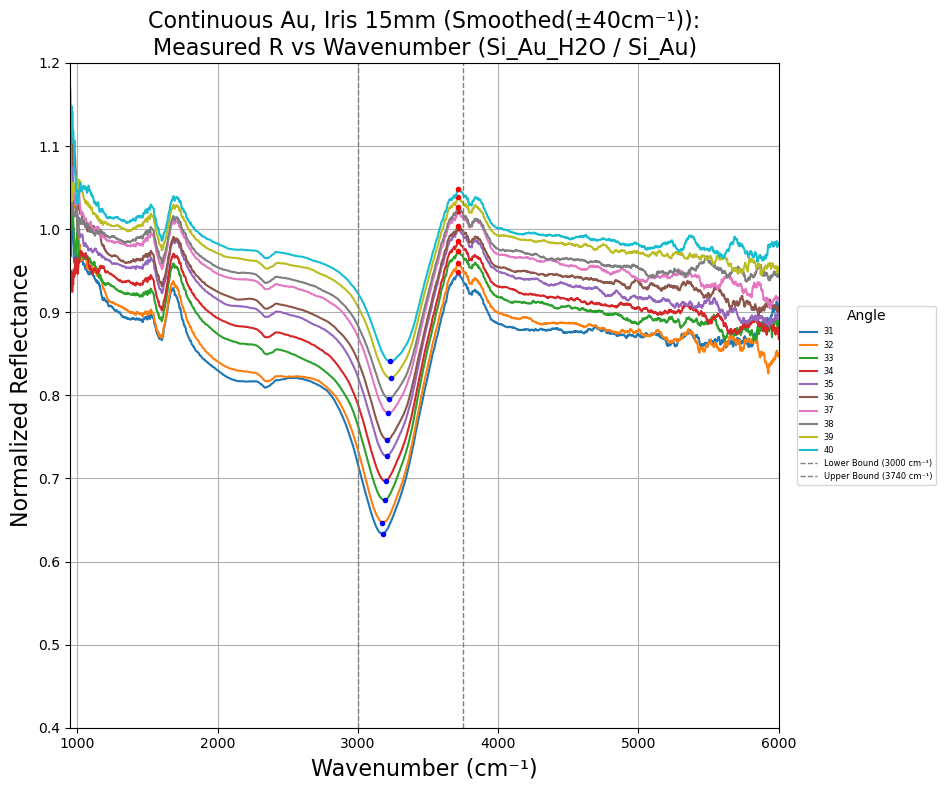

In [8]:
# --- SELECT angles
# selected_angles = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]  # Update this list as you wish
# selected_angles = np.round(np.arange(5,21, 1), 1)
# selected_angles = np.round(np.arange(21,31, 1), 1)
selected_angles = np.round(np.arange(31,41, 1), 1)
# selected_angles = np.round(np.arange(41,51, 1), 1)


# --- Plot reflectance vs wavenumber for selected angles ---
plt.figure(figsize=(12, 8))

for angle in selected_angles:
    if angle not in data_normed_smoothed:
        print(f"Warning: angle {angle}° not found in data_normed_smoothed.")
        continue

    df = data_normed_smoothed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Smoothed Normed R"].values

    # Plot main curve
    plt.plot(wavenumbers, reflectance, label=angle)

    # Find max and min within the visible x-range
    mask = (wavenumbers >= 3000) & (wavenumbers <= 3747)
    wn_crop = wavenumbers[mask]
    R_crop = reflectance[mask]

    max_idx = np.argmax(R_crop)
    min_idx = np.argmin(R_crop)
    wn_max, R_max = wn_crop[max_idx], R_crop[max_idx]
    wn_min, R_min = wn_crop[min_idx], R_crop[min_idx]
    # print(wn_max, R_max)
    # Plot max and min points
    plt.plot(wn_max, R_max, 'ro', markersize=3)  # red dot for max
    plt.plot(wn_min, R_min, 'bo', markersize=3)  # blue dot for min

# --- Customize plot ---
plt.title(
    f"Continuous Au, Iris 15mm (Smoothed(±{window}cm⁻¹)):\n"
    "Measured R vs Wavenumber (Si_Au_H2O / Si_Au)",
    fontsize=16
)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectance", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0.4, 1.2)
plt.grid(True)
# Add vertical lines at the mask bounds
plt.axvline(3000, color='gray', linestyle='--', linewidth=1, label='Lower Bound (3000 cm⁻¹)')
plt.axvline(3747, color='gray', linestyle='--', linewidth=1, label='Upper Bound (3740 cm⁻¹)')

plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=6)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend
plt.show()


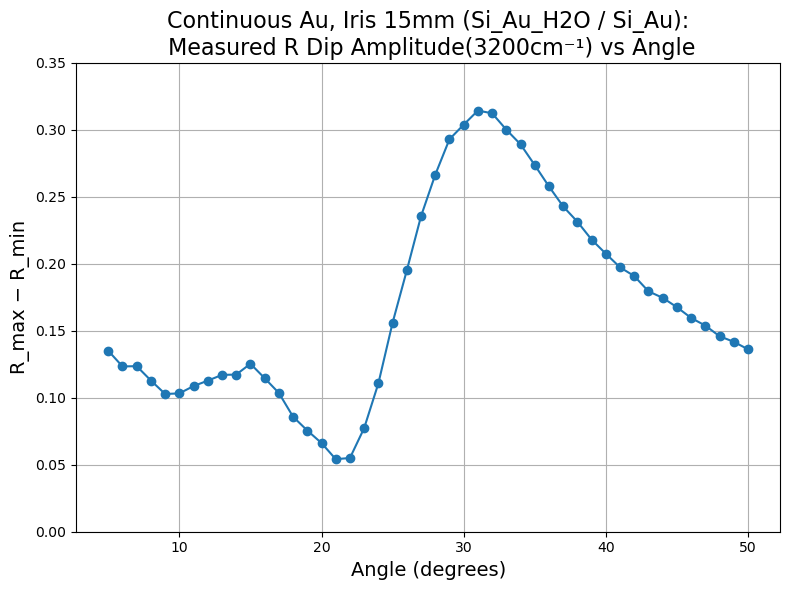

In [9]:
# --- Compute and store amplitudes for each angle ---

amplitudes_exp_3200 = []

for angle in np.arange(5, 51):  # Angles from 5 to 50 inclusive
    angle = round(angle, 1)
    if angle not in data_normed_smoothed:
        continue

    df = data_normed_smoothed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Smoothed Normed R"].values

    # Restrict to target wavenumber range
    mask = (wavenumbers >= 3000) & (wavenumbers <= 3747)
    wn_crop = wavenumbers[mask]
    R_crop = reflectance[mask]

    if len(R_crop) == 0:
        continue

    R_max = np.max(R_crop)
    R_min = np.min(R_crop)
    amplitude = R_max - R_min

    
    amplitudes_exp_3200.append(amplitude)

# --- Plot amplitude vs angle ---
plt.figure(figsize=(8, 6))
plt.plot(sorted(data_normed.keys()), amplitudes_exp_3200, marker='o', linestyle='-', label='Experiment')

plt.title(f"Continuous Au, Iris 15mm (Si_Au_H2O / Si_Au):\n Measured R Dip Amplitude(3200cm⁻¹) vs Angle",fontsize=16)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0, 0.35)
plt.grid(True)
plt.tight_layout()
plt.show()


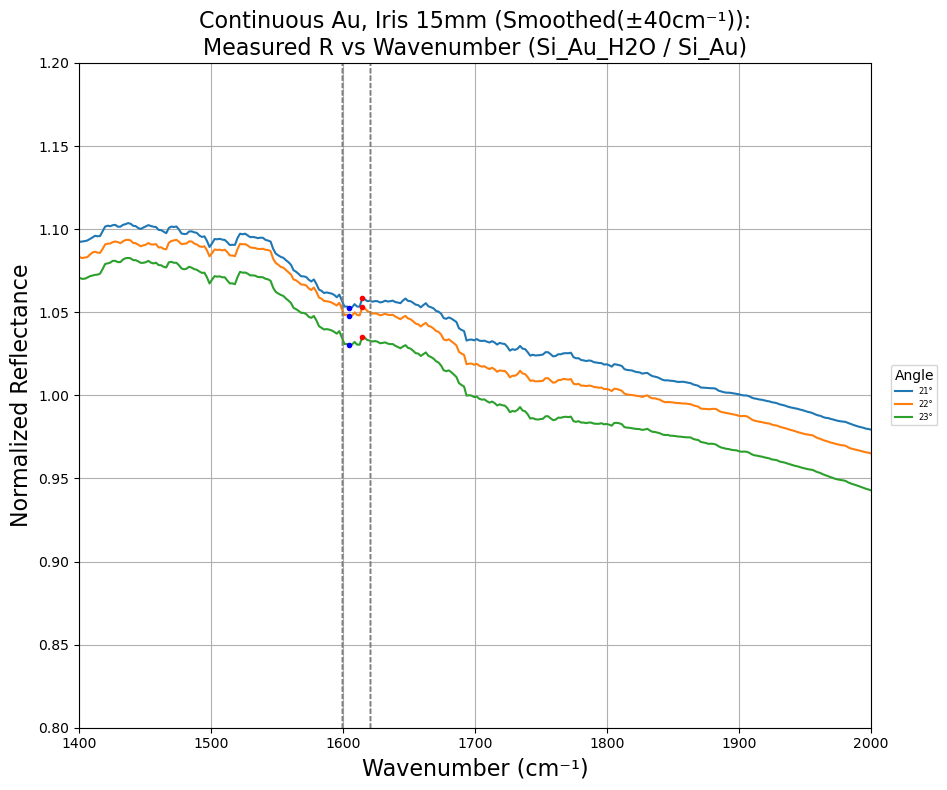

In [10]:
# --- Adjustable target angles ---
target_angles = [21, 22, 23]  # You can change this as needed

# --- Define angle groups and bounds ---
angle_groups = {
    "group1": {
        "angles": np.round(np.arange(5, 21, 1), 1),
        "bd_low": 1590,
        "bd_high": 1680
    },
    "group2": {
        "angles": np.round(np.arange(21, 26, 1), 1),
        "bd_low": 1599,
        "bd_high": 1620
    },
    "group3": {
        "angles": np.round(np.arange(26, 51, 1), 1),
        "bd_low": 1550,
        "bd_high": 1700
    }
}

# --- Build lookup dictionary: angle → (bd_low, bd_high) ---
angle_bounds = {}
for group in angle_groups.values():
    for a in group["angles"]:
        angle_bounds[a] = (group["bd_low"], group["bd_high"])

# --- Plot reflectance vs wavenumber ---
plt.figure(figsize=(12, 8))

for angle in target_angles:
    if angle not in data_normed_smoothed:
        print(f"Warning: angle {angle}° not found in data_normed_smoothed.")
        continue

    if angle not in angle_bounds:
        print(f"Warning: angle {angle}° has no defined bounds.")
        continue

    bd_low, bd_high = angle_bounds[angle]

    df = data_normed_smoothed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Smoothed Normed R"].values

    # Plot main curve
    plt.plot(wavenumbers, reflectance, label=f"{angle}°")

    # Apply bounds to crop region
    mask = (wavenumbers >= bd_low) & (wavenumbers <= bd_high)
    wn_crop = wavenumbers[mask]
    R_crop = reflectance[mask]

    if len(R_crop) == 0:
        continue

    max_idx = np.argmax(R_crop)
    min_idx = np.argmin(R_crop)
    wn_max, R_max = wn_crop[max_idx], R_crop[max_idx]
    wn_min, R_min = wn_crop[min_idx], R_crop[min_idx]

    # Plot max and min points
    plt.plot(wn_max, R_max, 'ro', markersize=3)
    plt.plot(wn_min, R_min, 'bo', markersize=3)

    # Add vertical bounds (if not already drawn)
    plt.axvline(bd_low, color='gray', linestyle='--', linewidth=1)
    plt.axvline(bd_high, color='gray', linestyle='--', linewidth=1)

# --- Customize plot ---
plt.title(
    f"Continuous Au, Iris 15mm (Smoothed(±{window}cm⁻¹)):\n"
    "Measured R vs Wavenumber (Si_Au_H2O / Si_Au)",
    fontsize=16
)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectance", fontsize=16)
plt.xlim(1400, 2000)
plt.ylim(0.8, 1.2)
plt.grid(True)
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=6)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


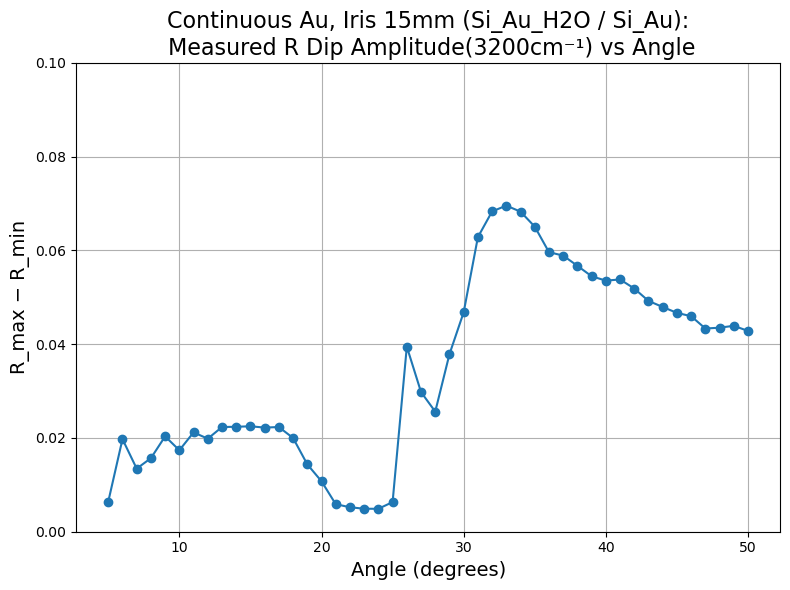

In [11]:
# --- Compute and store amplitudes for each angle ---

amplitudes_exp_1600 = []

for angle in np.arange(5, 51):  # Angles from 5 to 50 inclusive
    angle = round(angle, 1)
    if angle not in data_normed_smoothed:
        continue

    df = data_normed_smoothed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Smoothed Normed R"].values

    # Restrict to target wavenumber range
    if angle < 21:
        low_bd, high_bd = 1590, 1680
    elif 20 < angle < 26:
        low_bd, high_bd = 1599, 1620
    else:
        low_bd, high_bd = 1550, 1700

    mask = (wavenumbers >= low_bd) & (wavenumbers <= high_bd)
    wn_crop = wavenumbers[mask]
    R_crop = reflectance[mask]

    if len(R_crop) == 0:
        continue

    R_max = np.max(R_crop)
    R_min = np.min(R_crop)
    amplitude = R_max - R_min

    
    amplitudes_exp_1600.append(amplitude)

# --- Plot amplitude vs angle ---
plt.figure(figsize=(8, 6))
plt.plot(sorted(data_normed.keys()), amplitudes_exp_1600, marker='o', linestyle='-', label='Experiment')

plt.title(f"Continuous Au, Iris 15mm (Si_Au_H2O / Si_Au):\n Measured R Dip Amplitude(3200cm⁻¹) vs Angle",fontsize=16)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0, 0.1)
plt.grid(True)
plt.tight_layout()
plt.show()


--------------------------------------------

————————Theory calculations extract data————————

In [12]:
#path to Excel file
file_path = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250328/H2O refractive index.xlsx"
file_path2 = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250711/Ciesielski_nk_data.xlsx"

# Read the Excel file
df_full = pd.read_excel(file_path, engine='openpyxl', nrows=168)
df_full2 = pd.read_excel(file_path2, engine='openpyxl', nrows=447)

# Extract the 2nd, 3rd, and 4th columns (indexing starts from 0)
water_nk = df_full.iloc[:, [1, 2, 3]]
Au_nk = df_full2.iloc[:, [1, 2, 3]]

# Rename the columns for clarity
water_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]
Au_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]


In [13]:
# --- Interpolation and forming dataframe---
# --- Interpolate WATER ---
wn_water = water_nk["Wavenumber (cm⁻¹)"].values
n_water = water_nk["n (real)"].values
k_water = water_nk["k (imag)"].values

n_water_interp = interp1d(wn_water, n_water, kind='linear', fill_value="extrapolate")(exp_wavenumbers)
k_water_interp = interp1d(wn_water, k_water, kind='linear', fill_value="extrapolate")(exp_wavenumbers)

# Replace water_nk with interpolated version
water_nk = pd.DataFrame({
    "Wavenumber (cm⁻¹)": exp_wavenumbers,
    "n (real)": n_water_interp,
    "k (imag)": k_water_interp
})

# --- Interpolate GOLD (Au) ---
wn_Au = Au_nk["Wavenumber (cm⁻¹)"].values
n_Au = Au_nk["n (real)"].values
k_Au = Au_nk["k (imag)"].values

n_Au_interp = interp1d(wn_Au, n_Au, kind='linear', fill_value="extrapolate")(exp_wavenumbers)
k_Au_interp = interp1d(wn_Au, k_Au, kind='linear', fill_value="extrapolate")(exp_wavenumbers)

# Replace Au_nk with interpolated version
Au_nk = pd.DataFrame({
    "Wavenumber (cm⁻¹)": exp_wavenumbers,
    "n (real)": n_Au_interp,
    "k (imag)": k_Au_interp
})

# --- Merge using same logic as before ---
interp_n = Au_nk["n (real)"].values
interp_k = Au_nk["k (imag)"].values
target_wavenumbers = water_nk["Wavenumber (cm⁻¹)"].values  # same as exp_wavenumbers

Au_interp = pd.DataFrame({
    "Wavenumber (cm⁻¹)": target_wavenumbers,
    "n (real)": interp_n,
    "k (imag)": interp_k
})

# Final merged DataFrame (same as before)
merged_nk = pd.merge(
    water_nk,
    Au_interp,
    on="Wavenumber (cm⁻¹)",
    suffixes=("_water", "_Au")
)

————————Theory calculations————————

In [14]:
# Function to calculate reflectance for 3-layer system

def three_layer_reflectance(n0, n1, n2, d1, wavelength, theta0_deg, pol='s'):
    n0 = complex(n0)
    n1 = complex(n1)
    n2 = complex(n2)

    theta0_rad = np.radians(theta0_deg)

    sin_theta1 = (n0 / n1) * np.sin(theta0_rad)
    theta1 = np.arcsin(sin_theta1) 

    sin_theta2 = (n0 / n2) * np.sin(theta0_rad)
    theta2 = np.arcsin(sin_theta2)  

    def fresnel(n_i, n_j, theta_i, theta_j, pol):
        if pol == 's':
            return (n_i * np.cos(theta_i) - n_j * np.cos(theta_j)) / (n_i * np.cos(theta_i) + n_j * np.cos(theta_j))
        elif pol == 'p':
            return (n_j * np.cos(theta_i) - n_i * np.cos(theta_j)) / (n_j * np.cos(theta_i) + n_i * np.cos(theta_j))
        else:
            raise ValueError("Polarization must be 's' or 'p'")

    r01 = fresnel(n0, n1, theta0_rad, theta1, pol)
    r12 = fresnel(n1, n2, theta1, theta2, pol)
    delta = (2 * np.pi / wavelength) * n1 * d1 * np.cos(theta1)
    r_total = (r01 + r12 * np.exp(2j * delta)) / (1 + r01 * r12 * np.exp(2j * delta))
    return r_total

In [15]:
# Constants
n_Si = 3.417 + 0j  # Refractive index of Si
d_gold = 5.5e-9     # 10 nm film
n_air = 1.0 + 0j

# Arrays
wavenumbers = merged_nk["Wavenumber (cm⁻¹)"].values
wavelengths = 1e-2 / wavenumbers  # Convert cm⁻¹ to meters
n_Au = merged_nk["n (real)_Au"].values + 1j * merged_nk["k (imag)_Au"].values
n_water = merged_nk["n (real)_water"].values + 1j * merged_nk["k (imag)_water"].values

In [16]:
def compute_reflectance_ratios(theta_deg):
    r_water_s = []
    r_air_s = []
    r_water_p = []
    r_air_p = []

    R_normalized=[]
    R_air=[]
    Rs_air=[]
    Rp_air=[]
    R_water=[]
    Rs_water=[]
    Rp_water=[]

    for wavenumber, wl, n1, n2_water in zip(wavenumbers,wavelengths, n_Au, n_water):
        # Use your three_layer_reflectance() function
        r_s_water = three_layer_reflectance(n_Si, n1, n2_water, d_gold, wl, theta_deg, pol='s')
        r_s_air   = three_layer_reflectance(n_Si, n1, n_air, d_gold, wl, theta_deg, pol='s')

        r_p_water = three_layer_reflectance(n_Si, n1, n2_water, d_gold, wl, theta_deg, pol='p')
        r_p_air   = three_layer_reflectance(n_Si, n1, n_air, d_gold, wl, theta_deg, pol='p')

        r_water_s.append(r_s_water)
        r_air_s.append(r_s_air)
        r_water_p.append(r_p_water)
        r_air_p.append(r_p_air)

        R_s_air = abs(r_s_air)**2
        R_p_air = abs(r_p_air)**2 
        R_s_water = abs(r_s_water)**2
        R_p_water = abs(r_p_water)**2 

        R_air_single = (abs(r_s_air)**2 + abs(r_p_air)**2 )/2
        R_water_single = (abs(r_s_water)**2 + abs(r_p_water)**2 )/2 # Numerator

        R_ratio = R_water_single / R_air_single 

        R_normalized.append(R_ratio)
        R_air.append(R_air_single)
        Rs_air.append(R_s_air)
        Rp_air.append(R_p_air)
        R_water.append(R_water_single)
        Rs_water.append(R_s_water)
        Rp_water.append(R_p_water)


    return wavenumbers,wavelengths,r_s_water,r_air_s,r_water_p,r_air_p, R_normalized, R_water, R_air, Rs_water, Rp_water, Rs_air, Rp_air


In [17]:
#Theory Prepare output dictionary
angle_dict = {}
angles_deg = np.concatenate([np.arange(5, 50.1, 0.1)])

# Loop over angles
for angle in angles_deg:
    wavenumbers,wavelengths,r_s_water,r_air_s,r_water_p,r_air_p, R_normalized, R_water, R_air, Rs_water, Rp_water, Rs_air, Rp_air = compute_reflectance_ratios(angle)

    df = pd.DataFrame({
        "wavenumber": wavenumbers,
        "Rnorm": R_normalized,
        "R_water": R_water,
        "Rs_water": Rs_water,
        "Rp_water": Rp_water,
        "R_air": R_air,
        "Rs_air": Rs_air,
        "Rp_air": Rp_air

    })

    angle_dict[angle] = df


——————————Theory: Sliding average over angles———————————

In [18]:
angular_window = 6.34 # --- Angle Smoothing window  ---

In [19]:
# --- Smoothing calculations  ---
# --- Extract sorted angle list and wavenumbers ---
angles_all = np.array(sorted(angle_dict.keys()))
wavenumbers = np.array(angle_dict[angles_all[0]]['wavenumber'].values)


# --- Initialize smoothed component lists ---
R_water_smooth  = []
Rs_water_smooth = []
Rp_water_smooth = []
R_air_smooth    = []
Rs_air_smooth   = []
Rp_air_smooth   = []
Rnorm_smooth= []

# --- Smoothing loop ---
for angle in angles_all:
    neighbor_mask = (angles_all >= angle - angular_window) & (angles_all <= angle + angular_window)
    neighbor_angles = angles_all[neighbor_mask]

    # Average each component across neighbors
    R_water_avg  = np.mean([angle_dict[a]['R_water'].values for a in neighbor_angles], axis=0)
    Rs_water_avg = np.mean([angle_dict[a]['Rs_water'].values for a in neighbor_angles], axis=0)
    Rp_water_avg = np.mean([angle_dict[a]['Rp_water'].values for a in neighbor_angles], axis=0)
    R_air_avg    = np.mean([angle_dict[a]['R_air'].values for a in neighbor_angles], axis=0)
    Rs_air_avg   = np.mean([angle_dict[a]['Rs_air'].values for a in neighbor_angles], axis=0)
    Rp_air_avg   = np.mean([angle_dict[a]['Rp_air'].values for a in neighbor_angles], axis=0)
    Rnorm_avg = np.mean([angle_dict[a]['Rnorm'].values for a in neighbor_angles], axis=0)
    

    # Append to corresponding smoothed lists
    Rnorm_smooth.append(Rnorm_avg)
    R_water_smooth.append(R_water_avg)
    Rs_water_smooth.append(Rs_water_avg)
    Rp_water_smooth.append(Rp_water_avg)
    R_air_smooth.append(R_air_avg)
    Rs_air_smooth.append(Rs_air_avg)
    Rp_air_smooth.append(Rp_air_avg)

# --- Convert to arrays ---
R_water_smooth  = np.array(R_water_smooth)
Rs_water_smooth = np.array(Rs_water_smooth)
Rp_water_smooth = np.array(Rp_water_smooth)
R_air_smooth    = np.array(R_air_smooth)
Rs_air_smooth   = np.array(Rs_air_smooth)
Rp_air_smooth   = np.array(Rp_air_smooth)

Rnorm_smooth_ratio = R_water_smooth/R_air_smooth


In [20]:
# !!! Theory dataset !!!
anglelist = np.round(np.arange(5, 50.1, 0.1), 1) 
Rnorm_smooth_dict = dict(zip(anglelist, Rnorm_smooth_ratio))

——————————Theory: plotting Sliding average over angles———————————

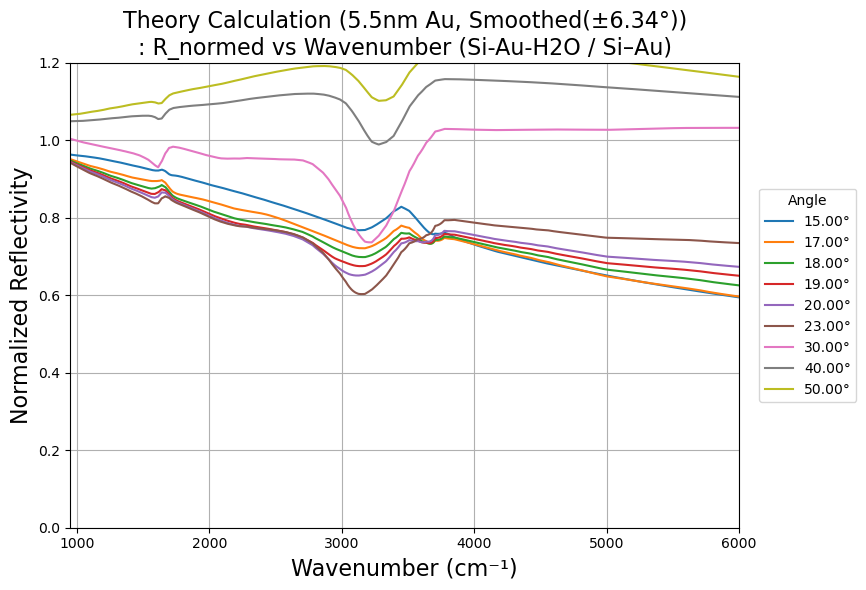

In [21]:
# R vs. wavenumber smoothed
# --- Select target angles (in degrees) ---
#target_angles = [22.2, 22.7, 23.3, 24.4, 25.6,33.5]    
target_angles = [15, 17,18, 19,20, 23, 30, 40, 50] 
# Match to closest available angles
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]

# --- Plot ---
plt.figure(figsize=(11, 6))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    #Rnorm_curve = Rnorm_smooth[idx, :]
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]
    plt.plot(wavenumbers, Rnorm_curve, label=f"{angle:.2f}°")

# --- Customize plot ---
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{angular_window}°))\n: R_normed vs Wavenumber (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)
# Place legend outside
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

plt.show()



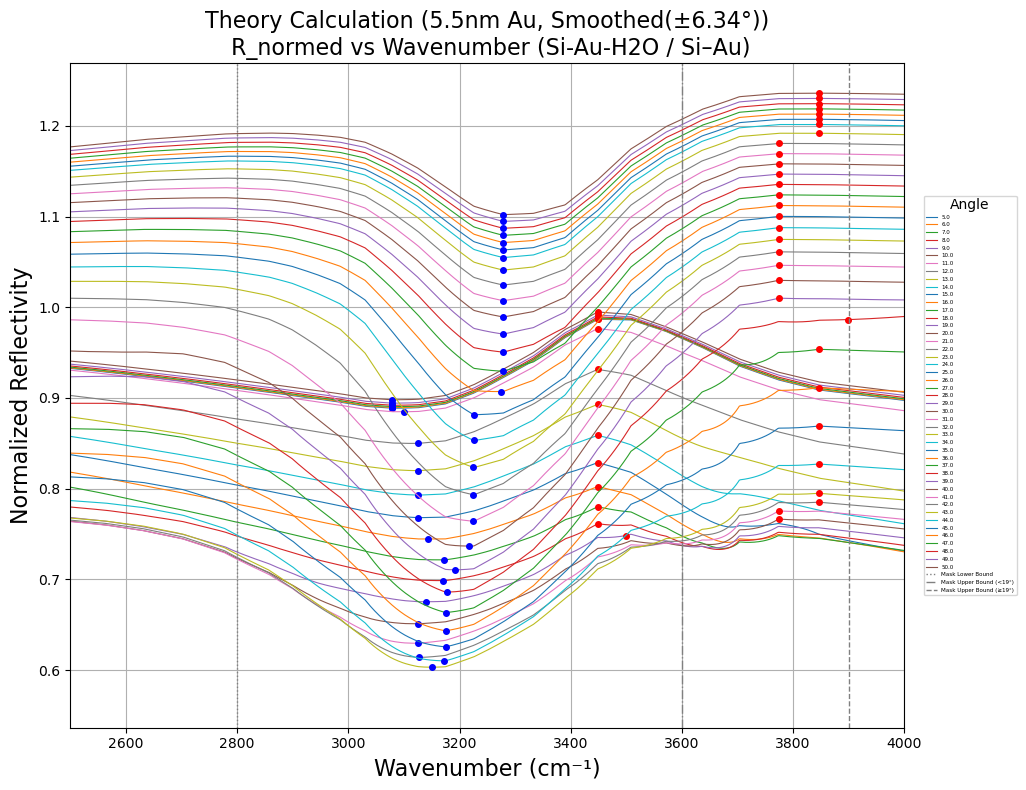

In [22]:
# --- Select target angles ---
target_angles = np.round(np.arange(5, 51, 1), 1)

# Match to closest available angles
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]

# --- Plot ---
plt.figure(figsize=(13, 8))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]

    # --- Use different wavenumber masks depending on angle ---
    if angle < 19:
        lower_bound, upper_bound = 2800, 3500
    else:
        lower_bound, upper_bound = 2800, 3900

    mask = (wavenumbers >= lower_bound) & (wavenumbers <= upper_bound)
    wn_crop = wavenumbers[mask]
    R_crop = Rnorm_curve[mask]

    # --- Find max and min in the range ---
    max_idx = np.argmax(R_crop)
    min_idx = np.argmin(R_crop)
    wn_max, R_max = wn_crop[max_idx], R_crop[max_idx]
    wn_min, R_min = wn_crop[min_idx], R_crop[min_idx]

    # --- Plot the main curve ---
    plt.plot(wavenumbers, Rnorm_curve, linewidth=0.8,label = f'{angle:.1f}')

    # --- Plot markers at max and min ---
    plt.plot(wn_max, R_max, 'ro', markersize=4)  # Red dot for max
    plt.plot(wn_min, R_min, 'bo', markersize=4)  # Blue dot for min

# --- Customize plot ---
plt.title(f"Theory Calculation ({d_gold * 1e9}nm Au, Smoothed(±{angular_window}°))\n R_normed vs Wavenumber (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(2500, 4000)
plt.grid(True)

# Add both vertical mask bounds
plt.axvline(2800, color='gray', linestyle=':', linewidth=1, label='Mask Lower Bound')
plt.axvline(3600, color='gray', linestyle='-.', linewidth=1, label='Mask Upper Bound (<19°)')
plt.axvline(3900, color='gray', linestyle='--', linewidth=1, label='Mask Upper Bound (≥19°)')

plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5),fontsize = 4)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


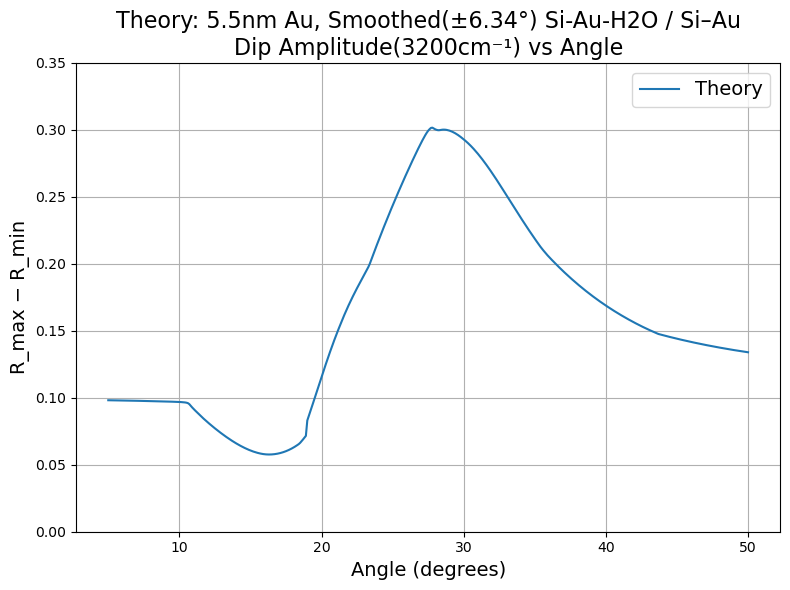

In [23]:
# --- Initialize storage ---
amplitudes_thr_3200 = []

# --- Loop through all angles in 0.1° steps ---
for angle in anglelist:

    # Find the index corresponding to this angle
    idx = np.argmin(np.abs(angles_all - angle))
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]

    # Apply different masks based on angle
    if angle < 19:
        lower_bound, upper_bound = 2800, 3500
    else:
        lower_bound, upper_bound = 2800, 3900

    mask = (wavenumbers >= lower_bound) & (wavenumbers <= upper_bound)
    wn_crop = wavenumbers[mask]
    R_crop = Rnorm_curve[mask]

    if len(R_crop) == 0:
        amplitudes_thr_3200.append(np.nan)  # or continue if you prefer to skip
        continue

    R_max = np.max(R_crop)
    R_min = np.min(R_crop)
    amplitude = R_max - R_min

    amplitudes_thr_3200.append(amplitude)

# --- Plot amplitude vs angle ---
plt.figure(figsize=(8, 6))
plt.plot(anglelist, amplitudes_thr_3200, linewidth=1.5, label='Theory')

plt.title(f"Theory: {d_gold * 1e9}nm Au, Smoothed(±{angular_window}°) Si-Au-H2O / Si–Au\nDip Amplitude(3200cm⁻¹) vs Angle", fontsize=16)
plt.legend(fontsize=14)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0, 0.35)
plt.grid(True)
plt.tight_layout()
plt.show()


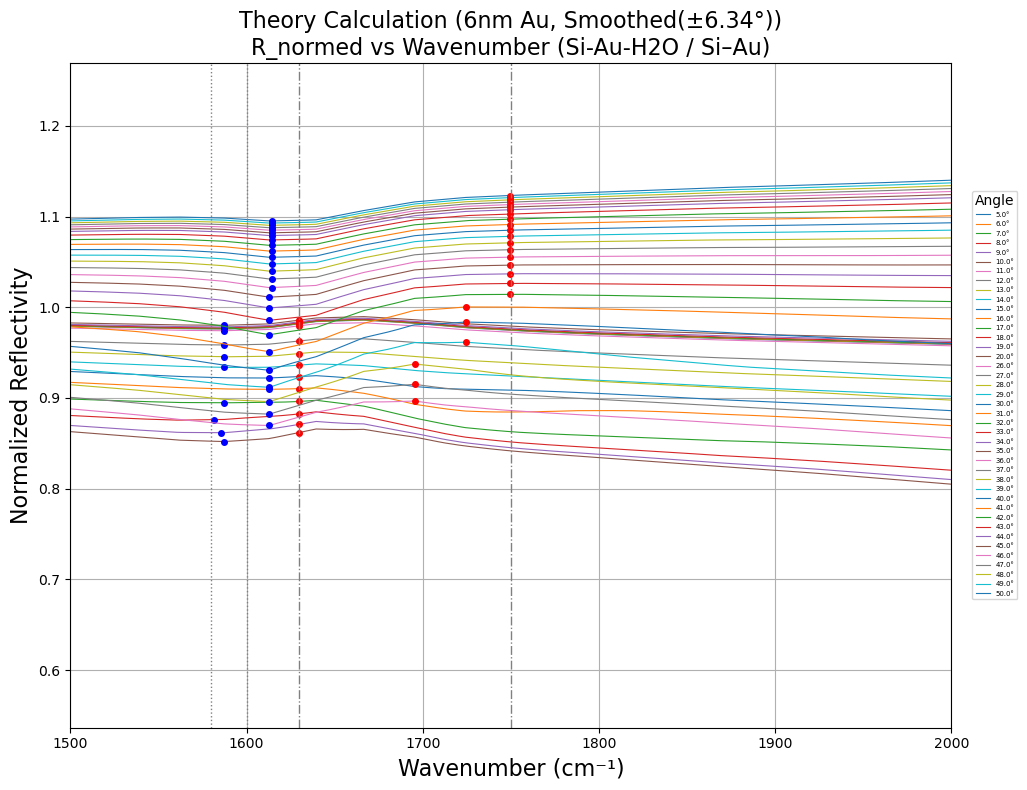

In [24]:
# --- Define angle groups and bounds ---
angle_groups = {
    "group1": {
        "angles": np.round(np.arange(5, 21, 1), 1),
        "bd_low": 1580,
        "bd_high": 1630
    },
    "group2": {
        "angles": np.round(np.arange(26, 51, 1), 1),
        "bd_low": 1600,
        "bd_high": 1750
    }
}

# --- Combine all angles and track their respective bounds ---
all_target_angles = []
angle_bounds = {}

for group in angle_groups.values():
    angles = group["angles"]
    bd_low = group["bd_low"]
    bd_high = group["bd_high"]
    for a in angles:
        all_target_angles.append(a)
        angle_bounds[a] = (bd_low, bd_high)

# --- Match to closest available angles ---
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in all_target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]
matched_angle_values = np.round(matched_angle_values, 1)

# --- Plot ---
plt.figure(figsize=(13, 8))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]

    # --- Use corresponding wavenumber bounds ---
    lower_bound, upper_bound = angle_bounds[angle]

    mask = (wavenumbers >= lower_bound) & (wavenumbers <= upper_bound)
    wn_crop = wavenumbers[mask]
    R_crop = Rnorm_curve[mask]

    if len(R_crop) == 0:
        continue

    # --- Find max and min in the range ---
    max_idx = np.argmax(R_crop)
    min_idx = np.argmin(R_crop)
    wn_max, R_max = wn_crop[max_idx], R_crop[max_idx]
    wn_min, R_min = wn_crop[min_idx], R_crop[min_idx]

    # --- Plot main curve ---
    plt.plot(wavenumbers, Rnorm_curve, linewidth=0.8, label=f'{angle:.1f}°')

    # --- Plot markers at max and min ---
    plt.plot(wn_max, R_max, 'ro', markersize=4)
    plt.plot(wn_min, R_min, 'bo', markersize=4)

# --- Customize plot ---
plt.title(
    f"Theory Calculation ({d_gold * 1e9:.0f}nm Au, Smoothed(±{angular_window}°))\n"
    "R_normed vs Wavenumber (Si-Au-H2O / Si–Au)",
    fontsize=16
)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(1500, 2000)
plt.grid(True)

# Add vertical lines for visual reference (if desired, e.g., for group1 bounds)
plt.axvline(1580, color='gray', linestyle=':', linewidth=1)
plt.axvline(1630, color='gray', linestyle='-.', linewidth=1)
plt.axvline(1600, color='gray', linestyle=':', linewidth=1)
plt.axvline(1750, color='gray', linestyle='-.', linewidth=1)

plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=5)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


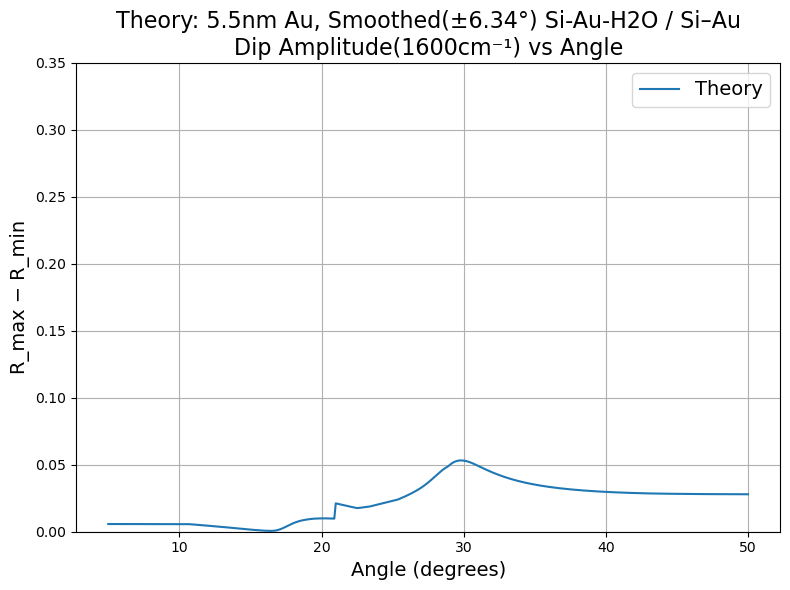

In [25]:
# --- Initialize storage ---
amplitudes_thr_1600 = []

# --- Loop through all angles in 0.1° steps ---
for angle in anglelist:

    # Find the index corresponding to this angle
    idx = np.argmin(np.abs(angles_all - angle))
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]

    # Apply different masks based on angle
    if angle < 21:
        lower_bound, upper_bound = 1580, 1630
    else:
        lower_bound, upper_bound = 1600, 1750

    mask = (wavenumbers >= lower_bound) & (wavenumbers <= upper_bound)
    wn_crop = wavenumbers[mask]
    R_crop = Rnorm_curve[mask]

    if len(R_crop) == 0:
        amplitudes_thr_1600.append(np.nan)  # or continue if you prefer to skip
        continue

    R_max = np.max(R_crop)
    R_min = np.min(R_crop)
    amplitude = R_max - R_min

    amplitudes_thr_1600.append(amplitude)

# --- Plot amplitude vs angle ---
plt.figure(figsize=(8, 6))
plt.plot(anglelist, amplitudes_thr_1600, linewidth=1.5, label='Theory')

plt.title(f"Theory: {d_gold * 1e9}nm Au, Smoothed(±{angular_window}°) Si-Au-H2O / Si–Au\nDip Amplitude(1600cm⁻¹) vs Angle", fontsize=16)
plt.legend(fontsize=14)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0, 0.35)
plt.grid(True)
plt.tight_layout()
plt.show()


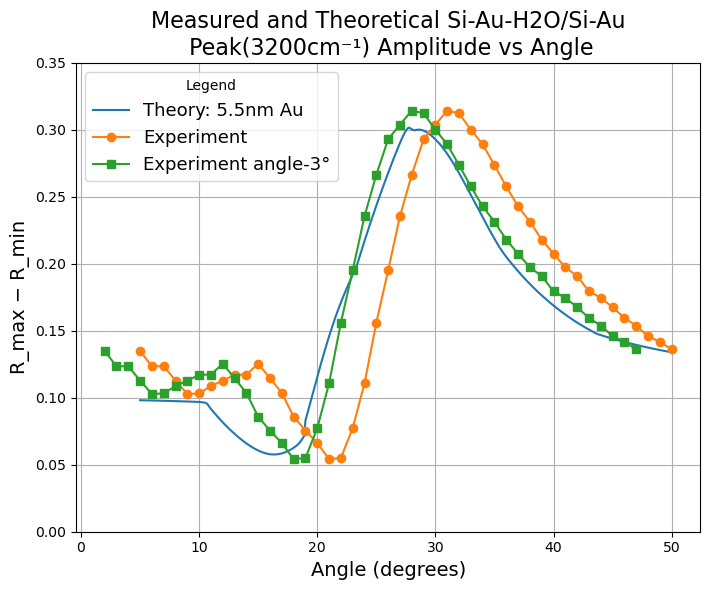

In [37]:
# --- Comparison ---
plt.figure(figsize=(9, 6))
plt.plot(anglelist, amplitudes_thr_3200, linewidth=1.5, label=f'Theory: {d_gold * 1e9:.1f}nm Au')
plt.plot(sorted(data_normed.keys()), amplitudes_exp_3200, marker='o', linestyle='-', label='Experiment')
plt.plot(np.array(sorted(data_normed.keys()))-3, amplitudes_exp_3200, marker='s', linestyle='-', label='Experiment angle-3°')


plt.title("Measured and Theoretical Si-Au-H2O/Si-Au\n Peak(3200cm⁻¹) Amplitude vs Angle", fontsize=16)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0, 0.35)
plt.grid(True)

# Legend outside
plt.legend(fontsize=13, title="Legend")
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for legend

plt.show()


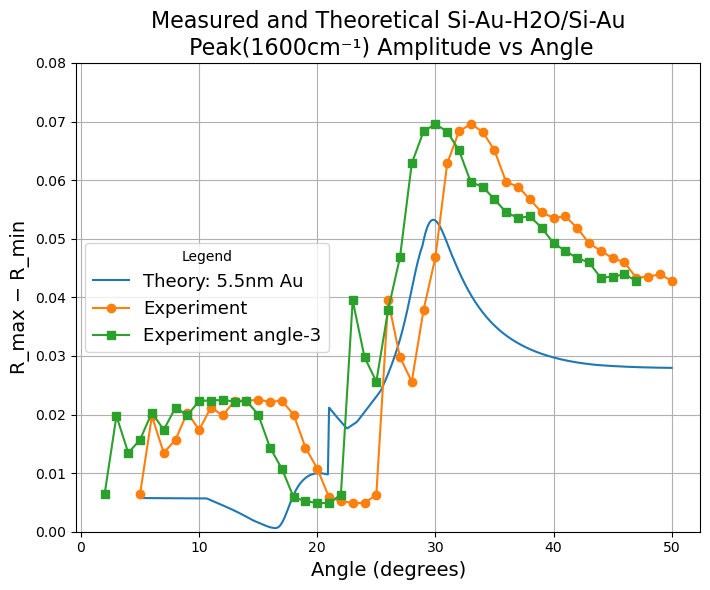

In [36]:
# --- Comparison ---
plt.figure(figsize=(9, 6))
plt.plot(anglelist, amplitudes_thr_1600, linewidth=1.5, label=f'Theory: {d_gold * 1e9:.1f}nm Au')
plt.plot(sorted(data_normed.keys()), amplitudes_exp_1600, marker='o', linestyle='-', label='Experiment')
plt.plot(np.array(sorted(data_normed.keys()))-3, amplitudes_exp_1600, marker='s', linestyle='-', label='Experiment angle-3')


plt.title("Measured and Theoretical Si-Au-H2O/Si-Au\n Peak(1600cm⁻¹) Amplitude vs Angle", fontsize=16)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0, 0.08)
plt.grid(True)

# Legend outside
plt.legend(fontsize=13, title="Legend", loc='center left')
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for legend

plt.show()
